# Introduction

While it shouldn't be the preferred measure of player evaluation, .OBP is still a reliable metric in assessing a player's overall ability to get on base. It tends to lack the contextual depth of other metrics, but it's simplicity makes .OBP a far more interpretable metric for all audiences. 

In the following analysis, I will attempt to predict a player's 2021 OBP based on his statistical performance thorugh prior seasons up until 2020. All data will be from the start of the 2016 season to the end of the 2021 season. To facilitate this analysis, I will leverage the *obp.csv* dataset (provided in the questionnaire, original source being FanGraphs) which includes the player name and their respective OBP/PA for that year. After performing some data sanitization, I will also incorporate other metrics I extracted through FanGraphs, of which I believe are the most correlated variables to a player's .OBP. I will also need to determine how to accomodate for different types of players, including those who have had varying levels of PAs across 2021 and previous years (due injury, opting out during 2020, or other reasons). I will then experiment with an array of predictive models, selecting the lowest RMSE model to implement and analyzing the predicted results relative to the actual values.

In summary, I hope to accomplish the following in my analysis:
1. Incorporate ***new variables which are assosciated with .OBP and add value to my predictive models***
2. Identify the variables which are ***the most highly correlated to 2021 .OBP***
3. Determine how I can accomodate for players with ***varying PAs across 2021 and previous years**
4. Experiment with various of predictive methods and identify the ***most 'optimal' predictive model*** to predict 2021 .OBP
5. Levarage this new model & identify some ***key insights*** based on the results
6. Acknowledge the **deficiencies** within my analysis

**DATA SOURCES:** FanGraphs

**IMAGE CREDITS:** MLB.com

In [38]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy import stats

# Ignore warnings for all of the future plots
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Load in the dataset
obp = pd.read_csv('../data/obp.csv')
obp.head()

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
obp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        572 non-null    object 
 1   playerid    572 non-null    int64  
 2   birth_date  572 non-null    object 
 3   PA_21       572 non-null    int64  
 4   OBP_21      572 non-null    float64
 5   PA_20       466 non-null    float64
 6   OBP_20      466 non-null    float64
 7   PA_19       437 non-null    float64
 8   OBP_19      437 non-null    float64
 9   PA_18       359 non-null    float64
 10  OBP_18      359 non-null    float64
 11  PA_17       298 non-null    float64
 12  OBP_17      298 non-null    float64
 13  PA_16       247 non-null    float64
 14  OBP_16      247 non-null    float64
dtypes: float64(11), int64(2), object(2)
memory usage: 67.2+ KB


Observing the dataset, there are **572 hitters** in which I will be analyzing & predicting .OBP for. There is a clear discrepancy between 2021 and the previous years which can be attributed to multiple reasons:
* Players making their debut somewhere in this timeline
* Players being injured for entire seasons, but then returning for others
* Players opting-out of the 2020 season (season which occured during the COVID-19 pandemic)
These are just a few of the possible reasons for this discrepancy. 

I will be proceeding with the analysis as is because I believe imputation would be inappropriate. Some players who have NAN values may exhibit extremely above-average or below-average performances relative to other players, or their performance could significantly fluctuate year to year. As such, I would rather rely on the players' most recent data rather than impute data based on the average.

# Data Preparation - Removing Players & Adding Additional Data

Before proceeding with my analysis, it's important that I make a few modifications to my dataset

### 1) Remove players with N/A values all throughout 2020 - 2016

While I don't want to reduce my player pool, it would be nearly impossible to predict for players just making their debut in 2021 (no historical data to go off of). I could incorporate some of their minor league statistics and use it as basis of projection, but this would extend my analysis far beyond its original scope. As such, I decided to drop these players from my analysis

In [41]:
# Define the PA columns for the years 2016 through 2020
pa_columns = ['PA_20', 'PA_19', 'PA_18', 'PA_17', 'PA_16']

# Function to check if a player has no data (all NaN) in the PA columns
def check_no_data(row):
    # Check if all values in the PA columns are either NaN or zero
    if row[pa_columns].isna().all():
        return True  # Flag as True if no data
    return False  # Otherwise, False

# Apply the check to each row in the 'obp' dataset
obp['No_Data'] = obp.apply(check_no_data, axis=1)

# Filter and display players with no data from 2016 to 2020
no_data_players = obp[obp['No_Data']]

# Display the players with no data in 2016 through 2020
no_data_players


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16,No_Data
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
14,Jose Siri,17452,1995-07-22,49,0.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
60,Jonathan India,21523,1996-12-15,631,0.376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
70,Matt Vierling,21558,1996-09-16,77,0.364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
77,Alfonso Rivas,21560,1996-09-13,49,0.388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Jose Godoy,15808,1994-10-13,40,0.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
555,Kevin Smith,20242,1996-07-04,36,0.194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
557,Jake Hager,12198,1993-03-04,30,0.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
567,Greg Deichmann,19872,1995-05-31,31,0.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [42]:
# Drop all of the 'no data' players from my obp dataset
obp = obp[~obp['No_Data']].reset_index(drop=True)

# Drop the 'No_Data' column
obp = obp.drop(columns=['No_Data'])

obp

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,0.406,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,0.323,323.0,0.338,117.0,0.308
502,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,0.326,450.0,0.318,391.0,0.383
504,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,NaN,NaN,NaN,NaN,NaN


### 2) Add More Metrics To The Dataset

In addition to the provided dataset, I decided to add a few more metrics sourced from external resources (FanGraphs). This includes: K%+, BB%+, SLG+, and AVG+. I believe all of these variables are likely to be correlated with .OBP to some degree, although I'll need to use a correlation matrix to validate this result. 

In [43]:
# Load in the dataset
additional = pd.read_csv('../data/Additional Data.csv')
additional.head()

,Season,Name,Team,K%+,BB%+,AVG+,SLG+,NameASCII,PlayerId,MLBAMID
0,2018,Enny Romero,- - -,0.0,0.0,394.078632,479.497673,Enny Romero,4001,544836
1,2016,Matt Albers,CHW,0.0,0.0,388.427523,471.855359,Matt Albers,4300,458006
2,2017,Sean Gilmartin,NYM,0.0,0.0,382.686122,457.433488,Sean Gilmartin,12781,543219
3,2017,Raisel Iglesias,CIN,0.0,0.0,382.686122,457.433488,Raisel Iglesias,17130,628452
4,2017,Erik Kratz,NYY,0.0,0.0,390.289257,348.935511,Erik Kratz,4403,456124


I'll now use **playerId** to join these two datasets. Before I'm able to do this, I'll need to format the metrics by their years (similar to how it has been formatted in the original dataset)

In [44]:
# Function to create new columns --> K%+ --> K%+_yr.....
for index, row in additional.iterrows():
        # 2016
    if row['Season'] == 2016:
        additional.loc[index, 'K%+_16'] = row['K%+']
        additional.loc[index, 'BB%+_16'] = row['BB%+']
        additional.loc[index, 'AVG+_16'] = row['AVG+']
        additional.loc[index, 'SLG+_16'] = row['SLG+']
        # 2017
    elif row['Season'] == 2017:
        additional.loc[index, 'K%+_17'] = row['K%+']
        additional.loc[index, 'BB%+_17'] = row['BB%+']
        additional.loc[index, 'AVG+_17'] = row['AVG+']
        additional.loc[index, 'SLG+_17'] = row['SLG+']
        # 2018
    elif row['Season'] == 2018:
        additional.loc[index, 'K%+_18'] = row['K%+']
        additional.loc[index, 'BB%+_18'] = row['BB%+']
        additional.loc[index, 'AVG+_18'] = row['AVG+']
        additional.loc[index, 'SLG+_18'] = row['SLG+']
        # 2019
    elif row['Season'] == 2019:
        additional.loc[index, 'K%+_19'] = row['K%+']
        additional.loc[index, 'BB%+_19'] = row['BB%+']
        additional.loc[index, 'AVG+_19'] = row['AVG+']
        additional.loc[index, 'SLG+_19'] = row['SLG+']
        # 2020
    elif row['Season'] == 2020:
        additional.loc[index, 'K%+_20'] = row['K%+']
        additional.loc[index, 'BB%+_20'] = row['BB%+']
        additional.loc[index, 'AVG+_20'] = row['AVG+']
        additional.loc[index, 'SLG+_20'] = row['SLG+']
        
    # Validate that all rows were accounted for
    else:
        print("Error")
        
additional


,Season,Name,Team,K%+,BB%+,AVG+,SLG+,NameASCII,PlayerId,MLBAMID,...,AVG+_17,SLG+_17,K%+_20,BB%+_20,AVG+_20,SLG+_20,K%+_19,BB%+_19,AVG+_19,SLG+_19
0,2018,Enny Romero,- - -,0.0,0.0,394.078632,479.497673,Enny Romero,4001,544836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,Matt Albers,CHW,0.0,0.0,388.427523,471.855359,Matt Albers,4300,458006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,Sean Gilmartin,NYM,0.0,0.0,382.686122,457.433488,Sean Gilmartin,12781,543219,...,382.686122,457.433488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,Raisel Iglesias,CIN,0.0,0.0,382.686122,457.433488,Raisel Iglesias,17130,628452,...,382.686122,457.433488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,Erik Kratz,NYY,0.0,0.0,390.289257,348.935511,Erik Kratz,4403,456124,...,390.289257,348.935511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,2020,Brady Singer,KCR,NaN,NaN,NaN,NaN,Brady Singer,25377,663903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6785,2020,Drew Rasmussen,MIL,NaN,NaN,NaN,NaN,Drew Rasmussen,25385,656876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6786,2020,Kwang Hyun Kim,STL,NaN,NaN,NaN,NaN,Kwang Hyun Kim,27458,547942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6787,2020,Shun Yamaguchi,TOR,NaN,NaN,NaN,NaN,Shun Yamaguchi,27460,685493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that I've created all the new columns for this new dataset, I'll group by playerID to ensure there is just a single entry per player

In [45]:
# Compile dataset for each player 
compiled_ad = additional.groupby('PlayerId').agg({
    'K%+_16': 'first',  
    'BB%+_16': 'first',
    'AVG+_16': 'first',
    'SLG+_16': 'first',
    'K%+_17': 'first',
    'BB%+_17': 'first',
    'AVG+_17': 'first',
    'SLG+_17': 'first',
    'K%+_18': 'first',
    'BB%+_18': 'first',
    'AVG+_18': 'first',
    'SLG+_18': 'first',
    'K%+_19': 'first',
    'BB%+_19': 'first',
    'AVG+_19': 'first',
    'SLG+_19': 'first',
    'K%+_20': 'first',
    'BB%+_20': 'first',
    'AVG+_20': 'first',
    'SLG+_20': 'first',
}).reset_index()

# Check the new dataframe
compiled_ad


,PlayerId,K%+_16,BB%+_16,AVG+_16,SLG+_16,K%+_17,BB%+_17,AVG+_17,SLG+_17,K%+_18,...,AVG+_18,SLG+_18,K%+_19,BB%+_19,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20
0,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,198,72.609566,31.172469,69.717760,54.444849,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,211,128.267677,0.000000,21.329233,26.122111,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,27458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2439,27459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,113.764926,155.294033,81.327592,95.334966
2440,27460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2441,27461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,80.405872,147.343925,99.472204,70.456906


With everything finally prepared in my added dataset, let's merge my new columns into the original dataset

In [46]:
# Merge new columns from 'additional' dataset to new 'dataset'
obp = obp.merge(compiled_ad[['PlayerId', 'K%+_16', 'BB%+_16','AVG+_16', 'SLG+_16', 
                            'K%+_17', 'BB%+_17','AVG+_17', 'SLG+_17', 
                            'K%+_18','BB%+_18', 'AVG+_18', 'SLG+_18',
                            'K%+_19', 'BB%+_19', 'AVG+_19','SLG+_19',
                            'K%+_20','BB%+_20', 'AVG+_20', 'SLG+_20']], left_on = 'playerid', right_on= 'PlayerId', how = 'left')

obp


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,AVG+_18,SLG+_18,K%+_19,BB%+_19,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,46.913714,50.632864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,124.943871,150.851454,87.471533,215.638791,114.878174,146.487350,97.809513,160.473805,115.907309,145.575520
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,98.161405,119.002604,119.403457,163.840770,100.835004,114.497724,76.267335,216.595571,108.909664,128.700744
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,81.340073,72.521890,174.050498,84.015113,54.737167,53.019074,108.193196,73.538014,108.857579,104.228403
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,115.177571,123.928142,91.636774,184.973494,109.464127,123.119201,61.824683,225.616628,142.273129,164.953103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,...,112.720690,90.715776,78.138728,49.749018,91.510296,85.498528,114.557502,95.166842,67.623647,47.481828
502,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,216.386392,0.000000,135.247295,316.545519
503,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,...,98.345677,80.641757,117.062274,131.176013,112.131034,112.186205,105.597687,75.797818,101.005307,92.632152
504,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,...,NaN,NaN,119.279362,106.928325,39.410761,45.444920,NaN,NaN,NaN,NaN


# Data Modelling

## Correlation Matrix - Evaluating My Predictors

Before I begin constructing any data models, it's important that I assess the predictive capability of each metric. To do this, I'll construct a correlation matrix

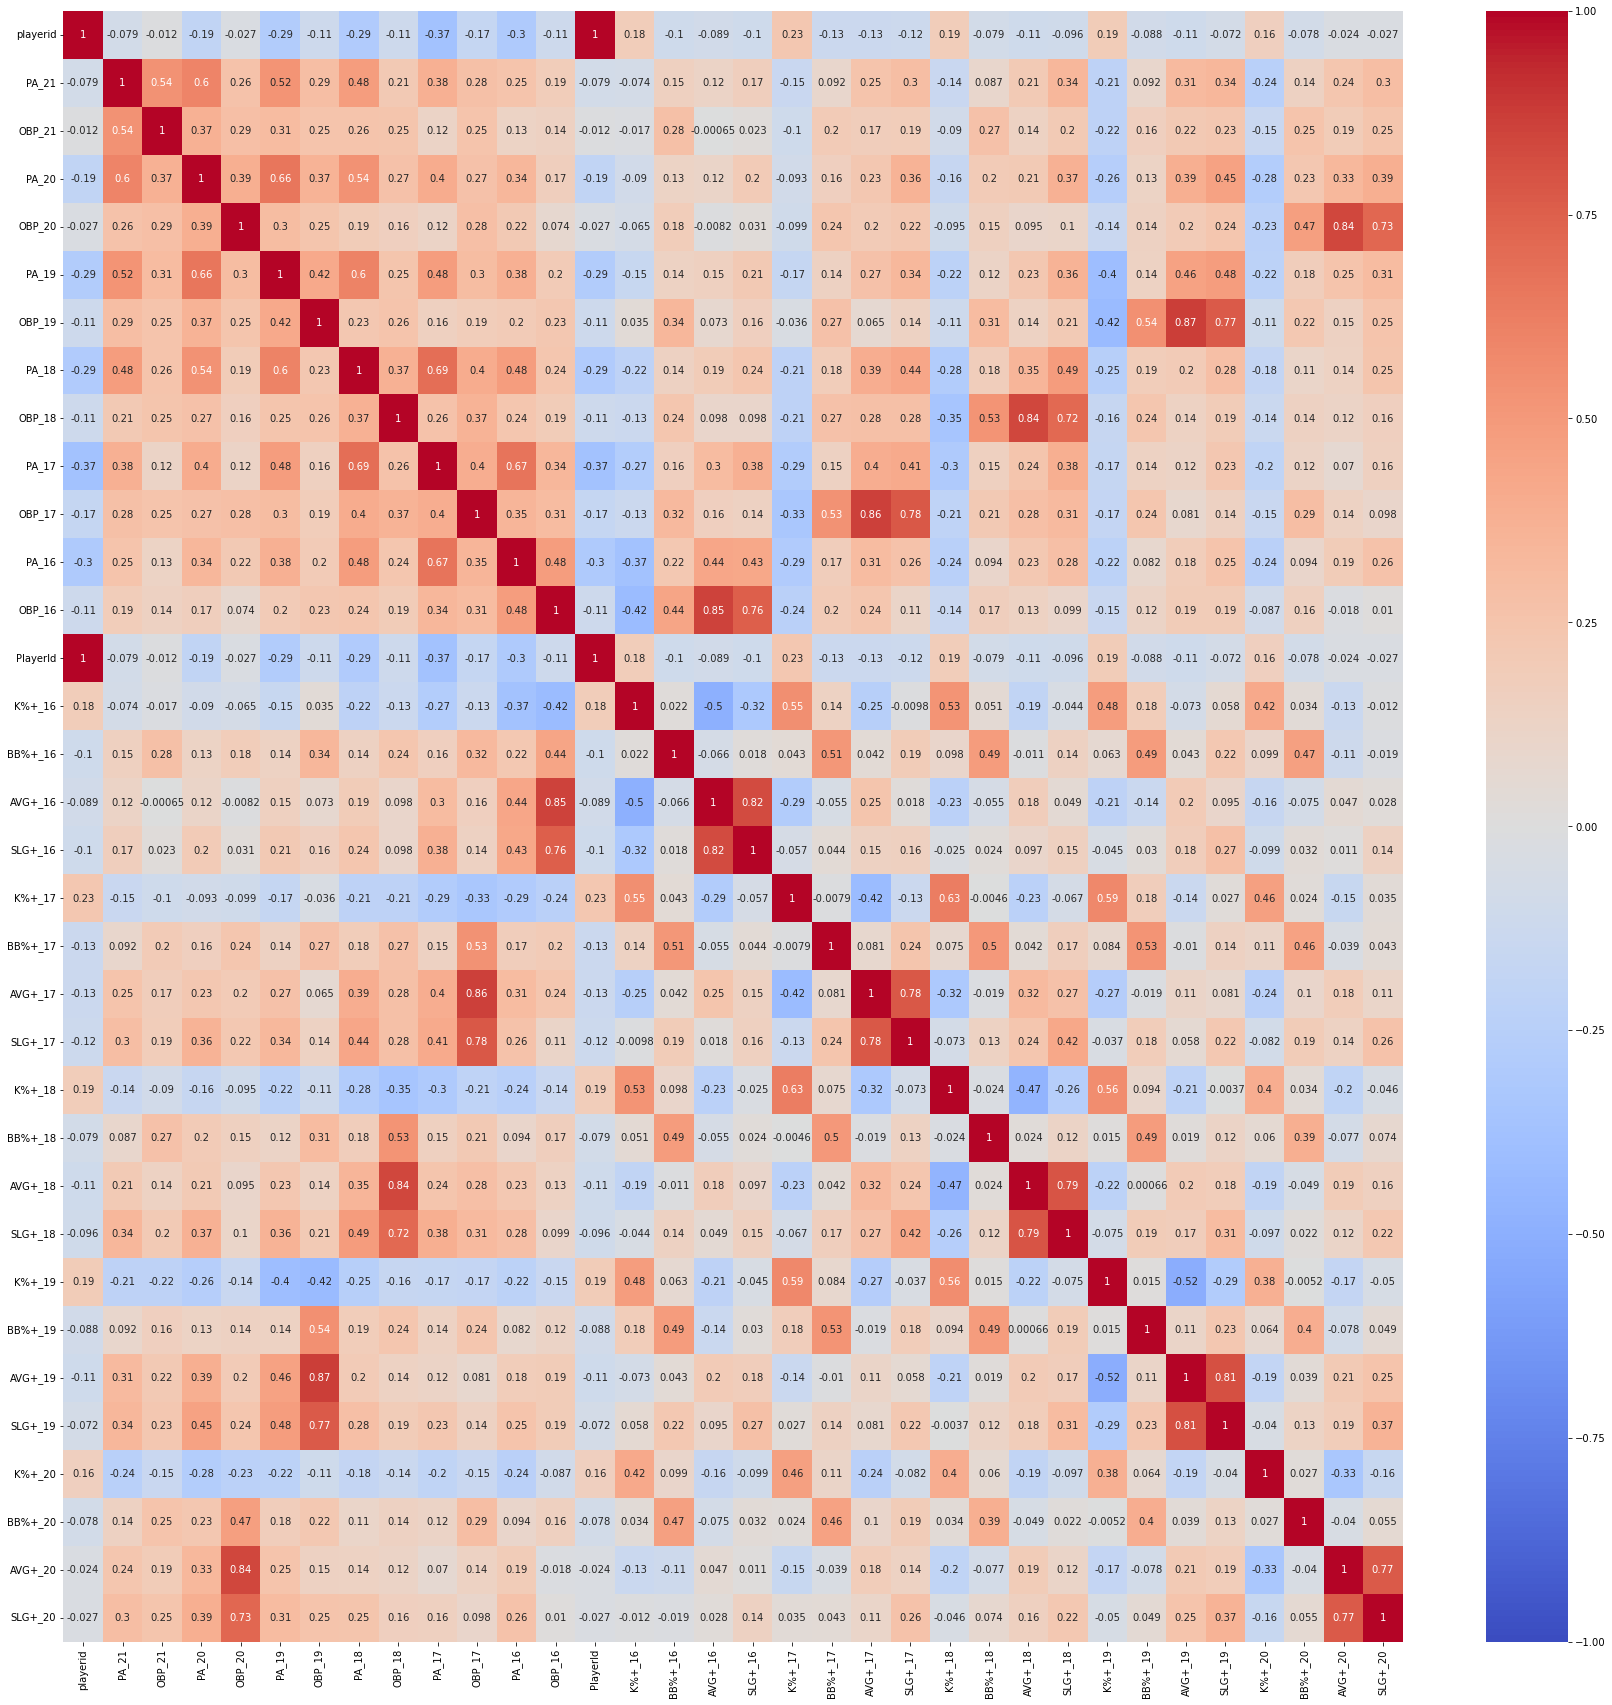

In [47]:
# Build the correlation matrix
correlation_matrix = obp.corr()

# Set up the figure
plt.figure(figsize=(30, 30))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)

# Show the plot
plt.show()


***How does each variable correlate with 2021 .OBP? Are there any notable trends***

* **Overall:** As you would expect, a variable's correlation with 2021 .OBP tends to **weaken as it gets further away from 2021** (demonstrating the fact that more recent performance is most favourable in this predictive analysis). **2020 appears to be an exception to this trend** (especially in .OBP) likely due to the smaller sample size of this period. Regardless, there is a **significant drop-off in 2016** with most correlations falling below 0.1. 
    * My goal should be to focus on more recent PAs rather than relying on historical data to project the player's .OBP. This will likely improve the accuracy of my models and overall results *(See next section to see how I accomodated for this)*
    * I should also try to ensure that I'm not only predicting for player performance in 2020, ensuring these players still have some other form of predictors to rely on (unless their level of PAs match to that of 2021). *(See next section to see how I accomodated for this)*
    * I should also accomodate for the **significant drop-off in 2016**. I should avoid using these metrics as predictors at all, but if I need to, I'll try and rely on variables with more predictive power
    

* **Previous OBP Values (Pre 2021) (0.29 - 0.14):** As one might expect, historical .OBP values had the most consistent and strongest (on average) correlation with 2021 .OBP. The correlation itself is only somewhat strong and positive (higher historical .OBP implicates a higher 2021 .OBP, on average), but is still relatively strong compared to others 
* **Plate Appearances (Pre 2021) (0.37 - 0.12):** Of all predictors, plate appearances had some of the strongest correlations to 2021 .OBP. It maintained a moderately strong, positive correlation (more PAs = higher .OBP, on average) above 0.30 until 2017/2016 where it fell below 0.15.
    * I should determine a method to accomodate for the number PAs in 2021. This likely had an influence on the player's .OBP within this year, so it should be a key consideration in their predicted result *(See next section to see how I accomodated for this)*
* **BB%+ (0.27 - 0.16)**: From the predictors I added, BB%+ appears to have the strongest correlation with 2021 .OBP (moderately strong, positive correlation all-around. Higher BB%+ implicates higher .OBP). This aligns with intuition as a player who tends to walk more would have a better .OBP.
* **AVG+ (0.22 -  -0.00065)**:  AVG+ also had a moderately strong, positive correlation with 2021 .OBP, but was not able to match the other metrics. It fell off significantly in 2016 as there is just a -0.00065 correlation at this point.
* **SLG+ (0.25 - 0.023)**:  SLG+ maintained a strong, positive correlation with 2021 .OBP up until 2016 (similar to AVG+). It still is the preferred predictor over AVG+ and K%+ as its correlations were stronger, on average.
* **K%+ (-0.22 -  -0.017)**: K%+ also maintained a somewhat strong, positive correlation with 2021 .OBP, but it did not match the strength of other metrics (similarly to AVG+). 

Based on the results, I decided to settle on the following predictors:
**Historical Plate Appearances, Historical .OBP Value, BB%+, and SLG+**


## Determining My Approach To Predict A Players .OBP

Before any models can be constructed, it's important that I establish how I'm going to predict the 2021 .OBP for each player. 

***Why not normalize any of the variables? Wouldn't this have improved the model's accuracy?***

While I would typically normalize the variables & predictors I am working with, it just wasn't appropiate in this scenario. My intention is for the results to be easily **interpretable**, allowing the user to immediately recognize the .OBP value and by how much the prediction may falter. Normalization disturbs this level of interpretability, so I decided to forgo its benefits in exchange for better model intrepretability. .OBP and PA do typically have a reasonable range on their own, making the benefits of normalization less benefitial. I also try to capture its benefits by using + stats instead of the conventional metrics, attempting to further improve my model accuracy.

***How am I going to accomodate for players with varying PAs across 2021 and previous years?*** 

Rather than predicting player results by every single year, it makes more sense to take into account their most recent performance. Based on the results from the correlation matrix, I'll only focus on **results beyond 2018**. Anything after 2018 is likely to be inaccurate. As such, I'll leverage the following system to classify players ('Most_Recent_PA' variable):

* **Criteria 1:** Identify the most recent year (2018 - 2020) in which the player had the same number (if not more) of PAs as they did in 2021

* **Criteria 2:** If there is no year which satisfies criteria 1, then use the most recent year in which the player had **at least 100 PAs**. 

* **Criteria 3:** If there is no year which satisfies criteria 2, then use the most recent year in which the player had **at least 50 PAs**. 

* **Final Criteria:** If a player does not meet any of the previous criteria, then use the most recent year in which he had **at least one PA**

In [117]:
# Function to find the most recent season in which the player had at least the same number of PAs as in 2021
def find_most_recent_pa_matching_2021(row):
    target_pa = row['PA_21']  # Set the target as 2021 PAs
    # Define the columns for PA from 2020 - 2018
    pa_columns = ['PA_20', 'PA_19', 'PA_18']
    
    # Try to find the most recent season with at least the same number of PAs as in 2021
    for season in pa_columns:
        if row[season] >= target_pa:
            return season[-2:]  
        
    # If it does not meet criteria #1, try to find the most recent season with at least 100 PAs
    for season in pa_columns:
        if row[season] >= 100:
            return season[-2:]  
    
    # If it does not meet criteria #2, find the most recent at least 50 PAs
    for season in pa_columns:
        if row[season] >= 50:
            return season[-2:]  
        
    # If it does not meet ANY of the criteria, assign the player to the most recent year with at least one PA
    for season in pa_columns:
        if row[season] >= 0:
            return season[-2:]   
    
    # Print "Error" for players who still do not have an assigned value
    print(f"Error: Issue with {row['Name']}")
    return "None"

# Apply the function to each row in the 'obp' dataset
obp['Most_Recent_PA'] = obp.apply(find_most_recent_pa_matching_2021, axis=1)

# Display the updated 'obp' dataset
obp.head()

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,K%+_19,BB%+_19,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20,Most_Recent_PA,No_2021_Data
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,87.471533,215.638791,114.878174,146.487350,97.809513,160.473805,115.907309,145.575520,20,False
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,119.403457,163.840770,100.835004,114.497724,76.267335,216.595571,108.909664,128.700744,19,False
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,174.050498,84.015113,54.737167,53.019074,108.193196,73.538014,108.857579,104.228403,19,False
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,91.636774,184.973494,109.464127,123.119201,61.824683,225.616628,142.273129,164.953103,19,False


In [118]:
# Show the number of players in each category
obp['Most_Recent_PA'].value_counts()

19    246
20    200
18     60
Name: Most_Recent_PA, dtype: int64

Applying these new classifications, I will predict the player's .OBP using the following rules:
* **Group 1 ('Most_Recent_PA') = 20**. I will use the player's predictors just from 2020.
* **Group 2 ('Most_Recent_PA') = 19**. I will use the player's predictors from 2019.
* **Group 3 ('Most_Recent_PA') = 18**. I will use the player's predictors from 2018.

In [102]:
# Create individual datasets for players I'll be poredicting for
players_2020 = obp[obp['Most_Recent_PA'] == "20"]
players_2019 = obp[obp['Most_Recent_PA'] == "19"]
players_2018 = obp[obp['Most_Recent_PA'] == "18"]

***What predictive methods will I use to construct my predictive model?***

For purposes of this analysis, I will only experiment with 3 different predictive methods. I've ensured that these models that are more diverse in their approaches, attempting to balance for each of their weaknesses and strengths. I also parameter-tuned the models where possible, attempting to mitigate the risk of overfitting/underfitting.
1. A Simple Linear Regression
2. XGBoost Model (Parameter-tuned)
3. Random Forest Model (Parameter-tuned)

***How will I evaluate my predictive models and their results?***

To evaluate these models, I'll use their **cross-validation RMSE scores**. This metric provides us with the exact .OBP value by which my predictions deviate from the actual results, while simultaneously considering for train and test splits (a critical component within data modelling). I can further contextualize the model's accuracy by taking it as a **% of the range**, providing a % by which my prediction is deviating (relative to the depth of the metric's range).

## Identifying The Most 'Optimal' Models

Now that I've established my principles and guidelines around data modelling, I can begin to construct my predictive models:

### Player Group 1: 2020 Data ('Most_Recent_PA' = 20)

***Model 1: Linear Regression Model (RMSE = 0.0478)***

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the model
model = LinearRegression()

# Fit model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.04784944078314686


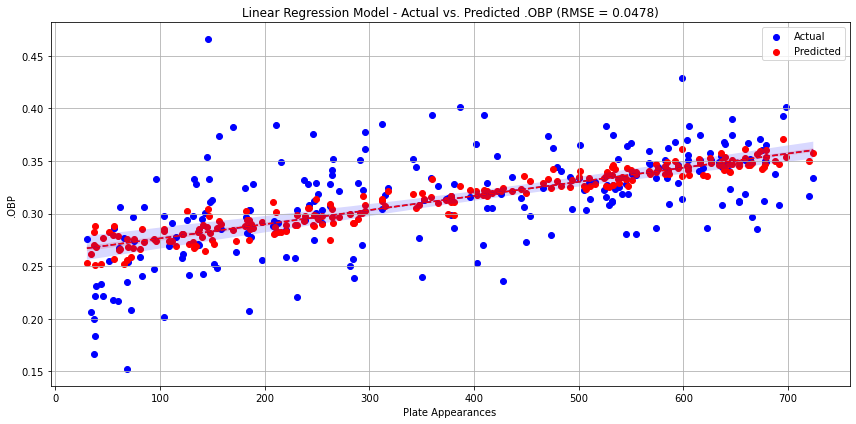

In [169]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2020['PA_21'], players_2020['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2020['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2020['PA_21'], y=players_2020['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2020['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Linear Regression Model - Actual vs. Predicted .OBP (RMSE = 0.0478)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Model 2: XGBoost (Parameter-tuned) (RMSE = 0.0463)***

In [51]:
!pip install xgboost

In [122]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))


Cross-validation RMSE =  0.047608649698074545


Let's see if I can improve my model's accuracy using parameter tuning

In [123]:
# Import GridSearchCV method form sklearn library
from sklearn.model_selection import GridSearchCV

# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Define the parameters to try
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150}
Best Cross-validation RMSE with Best Parameters: -0.04436521770422051


Let's apply these new parameters to my model

In [166]:
# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.05, max_depth = 3, min_child_weight = 1, n_estimators = 150)

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.046272811994528214


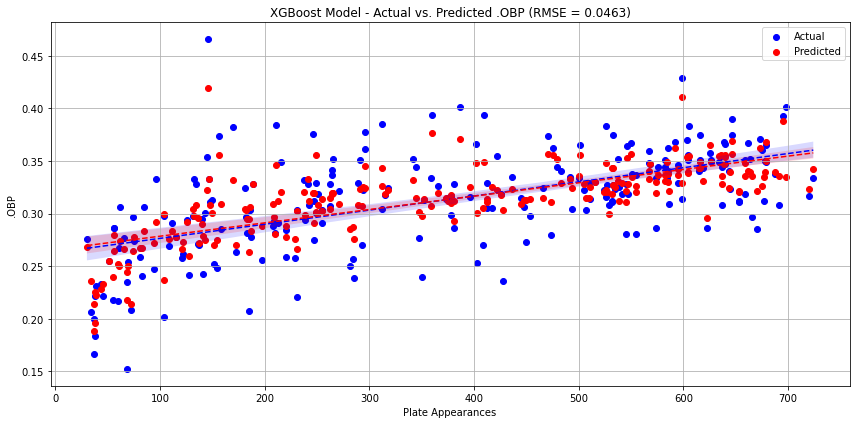

In [167]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2020['PA_21'], players_2020['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2020['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2020['PA_21'], y=players_2020['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2020['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('XGBoost Model - Actual vs. Predicted .OBP (RMSE = 0.0463)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Model 3: Random Forest (Parameter-tuned) (RMSE = 0.0459)***

In [132]:
from sklearn.ensemble import RandomForestRegressor

# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.04545437430429556


Let's see if I can improve my model's accuracy through parameter-tuning

In [129]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]
# Define target variable
Y = players_2020['OBP_21']
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()
# Fit the models
rf_model.fit(X, Y)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 70],
    'max_depth': [10, 20, 30],
    'max_features': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 40}
Best Cross-validation RMSE with Best Parameters: -0.0020431774434356395


Let's apply these new parameters to my model

In [246]:
# Define features
X = players_2020[['PA_21', 'PA_20', 'OBP_20', 'BB%+_20', 'SLG+_20']]

# Define target variable
Y = players_2020['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(max_depth = 20, max_features = 3, min_samples_leaf = 1, min_samples_split = 10, n_estimators = 40)

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.0459423577783456


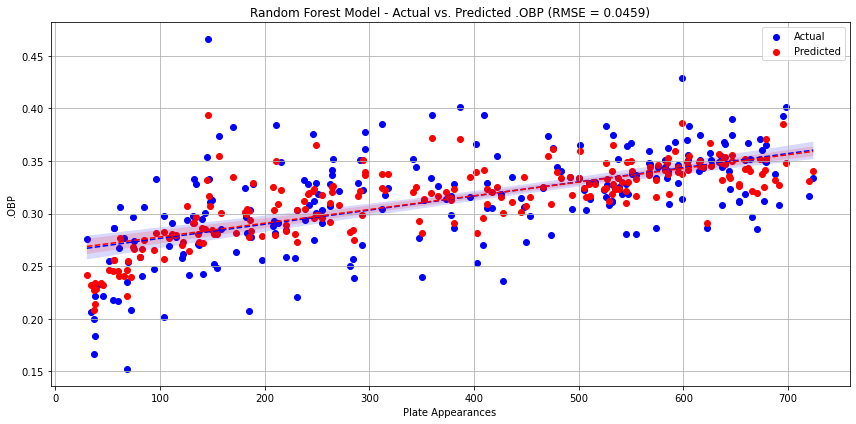

In [247]:
# Predicted values
predicted = rf_model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2020['PA_21'], players_2020['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2020['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2020['PA_21'], y=players_2020['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2020['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Random Forest Model - Actual vs. Predicted .OBP (RMSE = 0.0459)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## THIS IS MY SELECTED MODEL - APPEND PREDICTED RESULTS INTO PLAYERS_2020 DATASET ###
players_2020['Predicted_OBP_21'] = predicted

***Summary of Results***

![Pred Result 1](images/Pred%20Result%201.png)

### Player Group 2: 2019 Data ('Most_Recent_PA' = 19)

***Model 1: Linear Regression Model (RMSE = 0.0474)***

In [191]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]

# Define target variable
Y = players_2019['OBP_21']

# Initialize the model
model = LinearRegression()

# Fit model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.0474311226459107


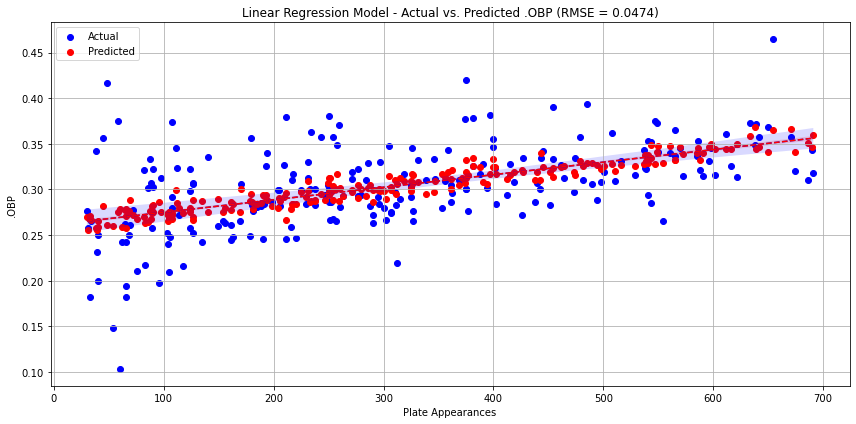

In [192]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2019['PA_21'], players_2019['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2019['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2019['PA_21'], y=players_2019['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2019['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Linear Regression Model - Actual vs. Predicted .OBP (RMSE = 0.0474)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## THIS IS MY SELECTED MODEL - APPEND PREDICTED RESULTS INTO PLAYERS_2019 DATASET ###
players_2019['Predicted_OBP_21'] = predicted

***Model 2: XGBoost (Parameter-tuned) (RMSE = 0.0515)***

In [150]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]

# Define target variable
Y = players_2019['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))


Cross-validation RMSE =  0.05601466338203298


Let's see if I can improve my model's accuracy with parameter tuning

In [151]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]

# Define target variable
Y = players_2019['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Define the parameters to try
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}
Best Cross-validation RMSE with Best Parameters: -0.046373117940004205


Let's apply these new parameters and visualize the model

In [160]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]

# Define target variable
Y = players_2019['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor(colsample_bytree = 1.0, learning_rate = 0.01, max_depth = 3, min_child_weight = 3, n_estimators = 200)

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.05145247997119255


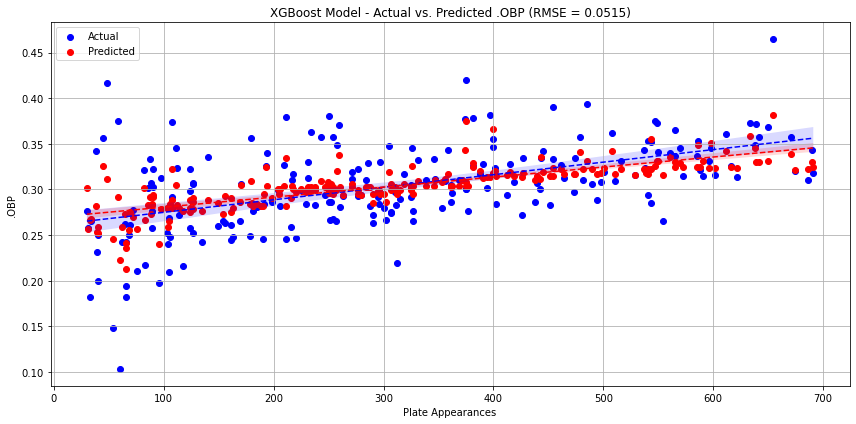

In [161]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2019['PA_21'], players_2019['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2019['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2019['PA_21'], y=players_2019['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2019['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('XGBoost Model - Actual vs. Predicted .OBP (RMSE = 0.0515)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Model 3: Random Forest (Parameter-tuned) (RMSE = 0.0506)***

In [155]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]

# Define target variable
Y = players_2019['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.0531361795167177


Let's see if I can improve my model's accuracy by tuning its parameters

In [156]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]
# Define target variable
Y = players_2019['OBP_21']
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()
# Fit the models
rf_model.fit(X, Y)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 70],
    'max_depth': [10, 20, 30],
    'max_features': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.0024926984102055212


Let's apply these new parameters to my model & visualize it 

In [158]:
# Define features
X = players_2019[['PA_21', 'PA_19', 'OBP_19', 'BB%+_19', 'SLG+_19']]
# Define target variable
Y = players_2019['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(max_depth = 10, max_features = 2, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 50)

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.05056900107139456


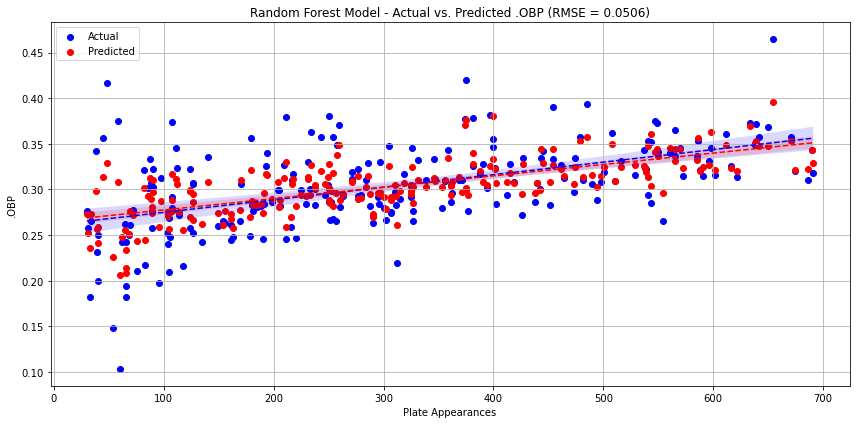

In [159]:
# Predicted values
predicted = rf_model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2019['PA_21'], players_2019['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2019['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2019['PA_21'], y=players_2019['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2019['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Random Forest Model - Actual vs. Predicted .OBP (RMSE = 0.0506)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Summary of Results***

![Pred Result 2](images/Pred%20Result%202.png)

### Player Group 3: 2018 Data ('Most_Recent_PA' = 18)

***Model 1: Linear Regression Model (RMSE = 0.0761)***

In [170]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]

# Define target variable
Y = players_2018['OBP_21']

# Initialize the model
model = LinearRegression()

# Fit model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.0761291555515897


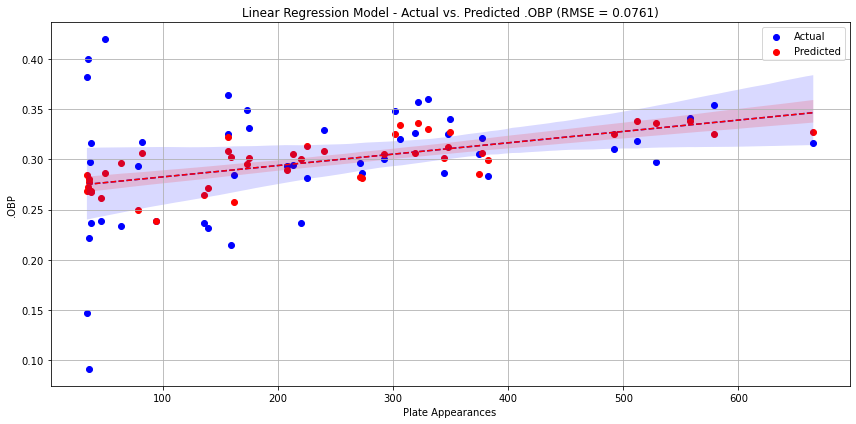

In [172]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2018['PA_21'], players_2018['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2018['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2018['PA_21'], y=players_2018['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2018['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Linear Regression Model - Actual vs. Predicted .OBP (RMSE = 0.0761)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Model 2: XGBoost (Parameter-tuned) (RMSE = 0.0710)***

In [173]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]

# Define target variable
Y = players_2018['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))


Cross-validation RMSE =  0.09399151642469801


Let's see if I can improve my model's accuracy through parameter-tuning

In [174]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]

# Define target variable
Y = players_2018['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor()

# Fit the model
model.fit(X, Y)

# Define the parameters to try
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.06209346128985049


Let's apply these new parameters to my model & visualize it

In [186]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]

# Define target variable
Y = players_2018['OBP_21']

# Initialize the XGB Regressor
model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.01, max_depth = 3, min_child_weight = 1, n_estimators = 50)

# Fit the model
model.fit(X, Y)

# Calculate cross-validation scores
scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')

# Print the Cross-validation RMSE
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores)))

Cross-validation RMSE =  0.07106506517940615


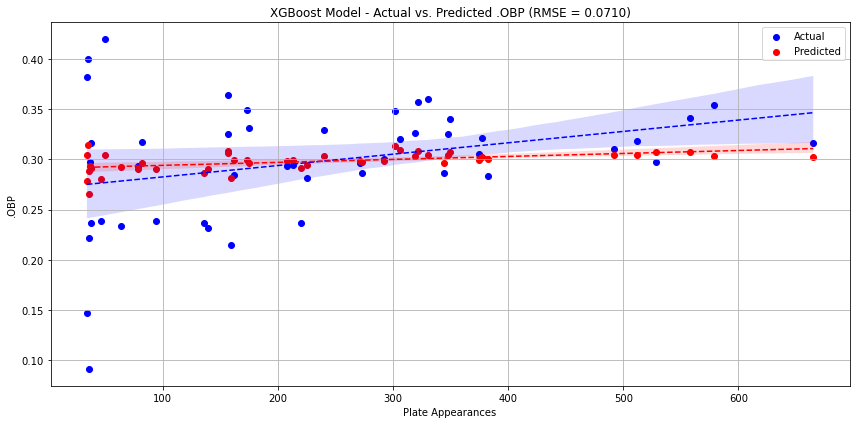

In [189]:
# Predicted values
predicted = model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2018['PA_21'], players_2018['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2018['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2018['PA_21'], y=players_2018['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2018['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('XGBoost Model - Actual vs. Predicted .OBP (RMSE = 0.0710)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## THIS IS MY SELECTED MODEL - APPEND PREDICTED RESULTS INTO PLAYERS_2018 DATASET ###
players_2018['Predicted_OBP_21'] = predicted

***Model 3: Random Forest (Parameter-tuned) (RMSE = 0.0727)***

In [177]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]

# Define target variable
Y = players_2018['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.08463733706297193


Let's see if I can improve my model's accuracy through parameter-tuning

In [180]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]
# Define target variable
Y = players_2018['OBP_21']
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()
# Fit the models
rf_model.fit(X, Y)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 70],
    'max_depth': [10, 20, 30],
    'max_features': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.005060049310399747


Let's apply these new parameters to my model & visualize the resutls

In [183]:
# Define features
X = players_2018[['PA_21', 'PA_18', 'OBP_18', 'BB%+_18', 'SLG+_18']]
# Define target variable
Y = players_2018['OBP_21']

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(max_depth = 20, max_features = 1, min_samples_leaf = 4, min_samples_split = 10, n_estimators = 50)

# Fit the models
rf_model.fit(X, Y)

# Calculate cross-validation scores 
scores_rf = cross_val_score(rf_model, X, Y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE = ", np.sqrt(-np.mean(scores_rf)))

Cross-validation RMSE =  0.07274274974010866


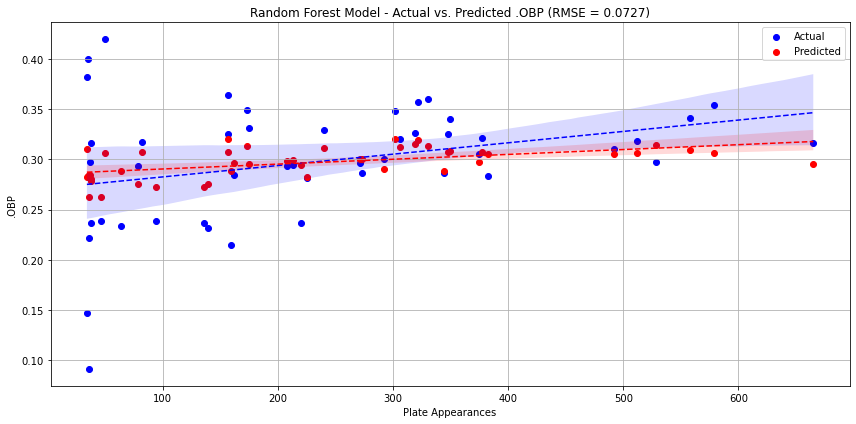

In [185]:
# Predicted values
predicted = rf_model.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted .OBP values
plt.scatter(players_2018['PA_21'], players_2018['OBP_21'], color='blue', label='Actual')
plt.scatter(players_2018['PA_21'], predicted, color='red', label='Predicted')
# Add a trend line
sns.regplot(x = players_2018['PA_21'], y=players_2018['OBP_21'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x = players_2018['PA_21'], y=predicted, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('Plate Appearances')
plt.ylabel('.OBP')
plt.title('Random Forest Model - Actual vs. Predicted .OBP (RMSE = 0.0727)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

***Summary of Results***

![Pred Result 3](images/Pred%20Result%203.png)


## Final Summary - Predictive Modelling

Now that I've predicted the 2021 .OBP for every player in the dataset, let's compile my predicted results

In [256]:
# Combine predicted results into single dataset
combined_predictions = pd.concat([
    players_2018[['playerid', 'Predicted_OBP_21']],
    players_2019[['playerid', 'Predicted_OBP_21']],
    players_2020[['playerid', 'Predicted_OBP_21']]
]).drop_duplicates(subset=['playerid'], keep='last')  # Drop if anything is duplicated


# Merge predicted results with original dataset (obp)
obp = obp.merge(combined_predictions, on='playerid', how='left')

obp


,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,BB%+_19,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20,Most_Recent_PA,No_2021_Data,Predicted_OBP_21
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False,0.313919
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,...,215.638791,114.878174,146.487350,97.809513,160.473805,115.907309,145.575520,20,False,0.393917
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,...,163.840770,100.835004,114.497724,76.267335,216.595571,108.909664,128.700744,19,False,0.386254
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,84.015113,54.737167,53.019074,108.193196,73.538014,108.857579,104.228403,19,False,0.304775
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,184.973494,109.464127,123.119201,61.824683,225.616628,142.273129,164.953103,19,False,0.365445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,...,49.749018,91.510296,85.498528,114.557502,95.166842,67.623647,47.481828,19,False,0.260286
502,Luis Campusano,22217,1998-09-29,38,0.184,4.0,0.500,NaN,NaN,NaN,...,NaN,NaN,NaN,216.386392,0.000000,135.247295,316.545519,20,False,0.214166
503,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,...,131.176013,112.131034,112.186205,105.597687,75.797818,101.005307,92.632152,20,False,0.271109
504,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,...,106.928325,39.410761,45.444920,NaN,NaN,NaN,NaN,19,False,0.278502


In [257]:
# Calculate Actual vs. Predicted differential (for next subsection)
obp['Pred_Diff'] = abs(obp['OBP_21'] - obp['Predicted_OBP_21']) 

In [262]:
# What is the average differential?
obp['Pred_Diff'].mean()

0.02460352979030193

### Top 15 Most Difficult To Predict Players (Highest .OBP Differentials)

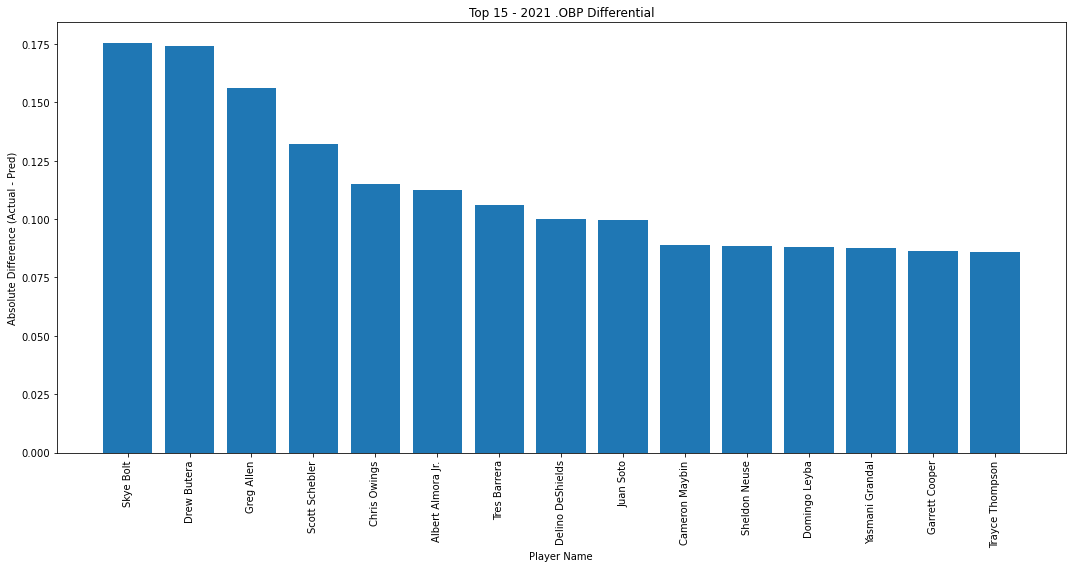

In [275]:
# Sort by differential
obp_sorted = obp.sort_values(by='Pred_Diff', ascending=False)

# Identify top 15 dIff
Top15diff = obp_sorted.head(15)

# Plotting the bar chart
plt.figure(figsize=(15, 8))
plt.bar(Top15diff['Name'], Top15diff['Pred_Diff'])

# Adding labels and title
plt.xlabel('Player Name')
plt.ylabel('Absolute Difference (Actual - Pred)')
plt.title('Top 15 - 2021 .OBP Differential')
          
# Rotate labels on the x-axis
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [276]:
Top15diff

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20,Most_Recent_PA,No_2021_Data,Predicted_OBP_21,Pred_Diff
504,Skye Bolt,17723,1994-01-15,60,0.103,NaN,NaN,11.0,0.182,NaN,...,39.410761,45.444920,NaN,NaN,NaN,NaN,19,False,0.278502,0.175502
505,Drew Butera,3411,1983-08-09,36,0.091,43.0,0.190,49.0,0.229,182.0,...,63.126143,52.251669,110.709317,50.165466,62.421828,48.699311,20,False,0.265205,0.174205
35,Greg Allen,16623,1993-03-15,48,0.417,32.0,0.281,256.0,0.290,291.0,...,90.422957,78.692503,131.910776,101.940370,63.366908,74.280842,19,False,0.261027,0.155973
497,Scott Schebler,12225,1990-10-06,34,0.147,1.0,0.000,95.0,0.253,430.0,...,47.873442,49.929373,0.000000,0.000000,0.000000,0.000000,19,False,0.278980,0.131980
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,...,54.737167,53.019074,108.193196,73.538014,108.857579,104.228403,19,False,0.304775,0.115225
501,Albert Almora Jr.,14109,1994-04-16,54,0.148,34.0,0.265,363.0,0.271,479.0,...,91.510296,85.498528,114.557502,95.166842,67.623647,47.481828,19,False,0.260286,0.112286
138,Tres Barrera,19977,1994-09-15,107,0.374,NaN,NaN,2.0,0.000,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,19,False,0.267865,0.106135
74,Delino DeShields,11379,1992-08-16,58,0.375,120.0,0.310,408.0,0.325,393.0,...,98.250916,78.923951,101.724805,82.873258,103.933573,76.710589,20,False,0.275094,0.099906
4,Juan Soto,20123,1998-10-25,654,0.465,196.0,0.490,659.0,0.401,494.0,...,109.464127,123.119201,61.824683,225.616628,142.273129,164.953103,19,False,0.365445,0.099555
503,Cameron Maybin,5223,1987-04-04,33,0.182,101.0,0.307,269.0,0.364,384.0,...,112.131034,112.186205,105.597687,75.797818,101.005307,92.632152,20,False,0.271109,0.089109


### Top 15 Least Difficult To Predict Players (Lowest .OBP Differentials)

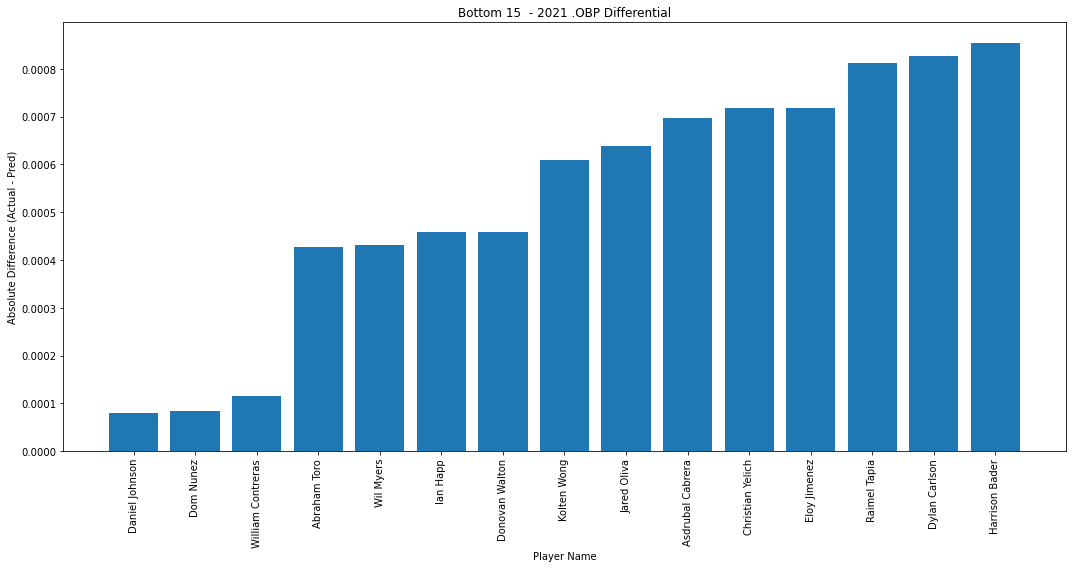

In [278]:
# Sort by differential
obp_sorted2 = obp.sort_values(by='Pred_Diff', ascending=True)

# Identify bottom 15 dff
Bottom15diff = obp_sorted2.head(15)

# Plotting the bar chart
plt.figure(figsize=(15, 8))
plt.bar(Bottom15diff['Name'], Bottom15diff['Pred_Diff'])

# Adding labels and title
plt.xlabel('Player Name')
plt.ylabel('Absolute Difference (Actual - Pred)')
plt.title('Bottom 15  - 2021 .OBP Differential')
          
# Rotate labels on the x-axis
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [279]:
Bottom15diff

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,...,AVG+_19,SLG+_19,K%+_20,BB%+_20,AVG+_20,SLG+_20,Most_Recent_PA,No_2021_Data,Predicted_OBP_21,Pred_Diff
379,Daniel Johnson,19643,1995-07-11,81,0.259,13.0,0.154,NaN,NaN,NaN,...,NaN,NaN,161.896241,84.998213,34.323742,20.117728,20,False,0.258920,0.000080
305,Dom Nunez,15055,1995-01-17,263,0.293,NaN,NaN,43.0,0.233,NaN,...,69.600620,92.177304,NaN,NaN,NaN,NaN,19,False,0.293085,0.000085
271,William Contreras,20503,1997-12-24,185,0.303,10.0,0.400,NaN,NaN,NaN,...,NaN,NaN,173.109114,0.000000,162.296754,118.704570,20,False,0.302885,0.000115
274,Abraham Toro,19844,1996-12-20,375,0.315,97.0,0.237,89.0,0.303,NaN,...,85.895247,87.394078,99.808198,34.174539,61.546019,66.596617,20,False,0.315428,0.000428
147,Wil Myers,10047,1990-12-10,500,0.334,218.0,0.353,490.0,0.321,343.0,...,92.709397,94.004957,111.170990,89.055209,116.804482,143.884327,20,False,0.333568,0.000432
156,Ian Happ,17919,1994-08-12,535,0.323,231.0,0.361,156.0,0.333,462.0,...,102.483362,126.784944,118.028941,140.072407,104.509273,119.903606,20,False,0.323458,0.000458
409,Donovan Walton,19314,1994-05-25,69,0.254,14.0,0.214,19.0,0.316,NaN,...,73.895176,42.604613,150.332224,78.926912,63.366907,55.710632,20,False,0.254459,0.000459
117,Kolten Wong,12532,1990-10-10,492,0.335,208.0,0.350,549.0,0.361,407.0,...,110.329255,94.949373,62.419152,103.707456,107.600058,77.387509,19,False,0.334391,0.000609
485,Jared Oliva,19968,1995-11-27,43,0.233,16.0,0.188,NaN,NaN,NaN,...,NaN,NaN,162.289794,0.000000,76.076604,44.514214,20,False,0.233638,0.000638
300,Asdrubal Cabrera,4962,1985-11-13,352,0.313,213.0,0.305,514.0,0.342,592.0,...,101.707323,99.743349,81.271884,96.209357,98.232246,106.209352,19,False,0.313698,0.000698


# Summary & Conclusion

Please see my presentation for a full summary & conclusion + **key insights**